# MSDS 422 - Practical Machine Learning - Week 8 - Assignment

##### Author: Jason De Melo - 2/27/2022

## Import Libraries

In [1]:
# General Libraries
import os
import cv2
from packaging import version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from datetime import datetime
from shutil import copy, copyfile, copy2

# Scikit-learn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_sample_image
from sklearn.model_selection import train_test_split #, cross_val_predict
from sklearn.metrics import roc_curve, auc, precision_recall_curve #accuracy_score, f1_score, confusion_matrix, 

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Verify Tensorflow and Keras Version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


## Pre-processing the data and images

All images are stored in the ``.\images`` folder. Pre-processing the data requires manipulating the image files according to the train and validation datasets. Also, the test set is included in the same folder. 
In order to organize the files, we will dynamically create folders for train, validation and test datasets, and copy the files from each dataset to the respective folder, by comparing the ``id`` to the actual file name. 
It is important to mention, we will use a small subset of the data to start building and refining the model, before we use all training data. The purpose of doing that is to save processing time while building and refining the model. That said, the train and validation folders should copy only the required files for the small subset of data.

#### Pre-processing auxiliary functions

In [4]:
# defines the random_state variable to be used globally
global_random_state = 42

# Image files folders
IMAGES = '.\images'
TRAIN = 'train'
VAL = 'validation'
TEST = 'test'

# Image dimensions
IMG_WIDTH = 32
IMG_HEIGHT = 32

def get_data(filename=None, data_size=1, target_variable=None):
    '''
        This function expects to receive a .CSV file name and read that into a Pandas DataFrame.
        The file can be split into smaller pieces, randomically, if we want to test a small subset of the file.

    Parameters
    ---------- 
    
    :param str filename:  .CSV filename
    :param float data_size: the percent size of the file that will be returned as the dataset. `data_size` should be between (0,1]. If `data_size = 1`, then the entire file is returned.
    :param array target_variables: a list containing the target variables names
    :return: this function returns a `Pandas DataFrame` with the independent variables and a Numpy array with the dependent variable
    '''
    
    #Check if data_size is between 0 and 1
    if data_size <= 0 or data_size > 1:
        print("Invalid data_size parameter. Data size should be greater than zero and less or equal to one.")
        return None, None, None
    
    if not isinstance(target_variable, str):
        print("target_variable should be a string.")
        return None, None, None

    # Add .CSV extension, if it is missing
    if '.csv' not in filename:
        filename += '.csv'
    
    # Check if file exists
    if os.path.getsize(filename) == 0:
        print(f"File {filename} does not exist.")
        return None, None, None

    # Read the whole file
    data = pd.read_csv(filename)

    # Separate the independent variables (X) from the dependent variables (y)
    X = data.drop(columns=[target_variable])

    # Labels are encoded
    label_encoder = LabelEncoder()
    encoder = OneHotEncoder(sparse=False)
    labels = data[target_variable].values
    labels_encoded = label_encoder.fit_transform(labels)
    labels_reshaped = labels_encoded.reshape(len(labels_encoded), 1)
    y = encoder.fit_transform(labels_reshaped)

    return X, y, label_encoder

def move_files(id_list=None, source=IMAGES, folder=None):
    if id_list is None or folder is None:
        return
    
    folder_name = os.path.join(source, folder)

    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    else:
        # Delete all files in the folder
        for file in os.listdir(folder_name):
            os.remove(os.path.join(folder_name, file))

    for id in id_list:
        file = f'{id}.jpg'
        if os.path.isfile(os.path.join(source, file)):
            src = f'{source}\{file}'
            dst = f'{source}\{folder}\{file}'
            copy2(src, dst)
    
    print(f'{len(os.listdir(folder_name))} files moved to destination folder: {folder_name}')

def read_img(source=IMAGES, folder=None, size=(IMG_WIDTH, IMG_HEIGHT)):
    if folder is None:
        return None
    
    data = []
    for file in os.listdir(os.path.join(source, folder)):
        id = file[0:file.find('.jpg')]   # Get id from file name
        img_file = cv2.imread(filename=os.path.join(source, folder, file), flags=cv2.IMREAD_GRAYSCALE)
        img_file = cv2.resize(src=img_file, dsize=size)
        img_file = img_file / 255.0

        img_array = np.array(img_file)
        img_array = img_array.reshape(size[0], size[1], 1)

        data.append([id, img_array]) 
    
    return np.array(data)

def split_data(X, y, test_size=0.2, img_path=IMAGES):
    '''
    Splits the dataset into training and validation sets. Creates folders for train and validation sets and moves the respecitve image files to the appropriate folders.

    Parameters
    ----------
    :param DataFrame X: Pandas DataFrame with the independent variavbles
    :param list y: list containing the target variables values
    :param float test_size: should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split.
    :param str img_path: folder where the image files are stored at
    :return: training and validation sets
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=global_random_state)
    
    # Move files from the train dataset
    print(f'X_train shape: {X_train.shape}, unique IDs: {len(X_train["id"])}')
    print(f'y_train shape: {y_train.shape}')
    move_files(X_train['id'], img_path, TRAIN)
    X_train = read_img(folder=TRAIN)

    # Move files from the validation dataset
    print(f'\nX_test shape: {X_test.shape}, unique IDs: {len(X_test["id"])}')
    print(f'y_test shape: {y_test.shape}')
    move_files(X_test['id'], img_path, VAL)
    X_test = read_img(folder=VAL)

    return X_train, X_test, y_train, y_test

#### Splitting the data into training and validation sets

In [5]:
# Read the file
X, y, label_encoder = get_data("train.csv", 1, 'species')

In [6]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.4) # test_size = 40% to guarantee the test data has all 99 species

X_train shape: (594, 193), unique IDs: 594
y_train shape: (594, 99)
594 files moved to destination folder: .\images\train

X_test shape: (396, 193), unique IDs: 396
y_test shape: (396, 99)
396 files moved to destination folder: .\images\validation


#### Display the training images

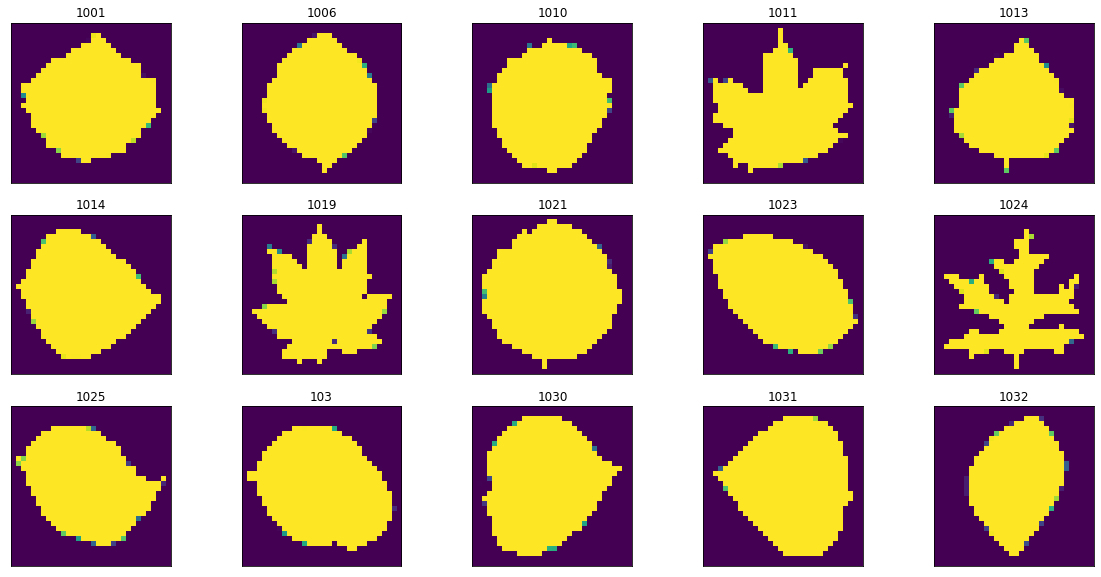

In [7]:
rows = 3
cols = 5
fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=(20,10))

for i in range(0, rows):
    for j in range(0, cols):
        axis[i,j].set_title(X_train[i*cols + j][0])
        axis[i,j].set_xticklabels('')
        axis[i,j].set_yticklabels('')
        axis[i,j].set_xticks([])
        axis[i,j].set_yticks([])
        axis[i,j].imshow(X_train[i*cols + j][1])


## Defining the Model

#### Auxiliary functions to create, train and test the model

In [8]:
def generate_model(filters=[], neurons=[], regularize=0.0, input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)):
    #model = Sequential()
    input_layer = Input(name='input_layer', shape=input_shape)
    
    previous_layer = input_layer
    for i in range(0, len(filters)):
        previous_layer = Conv2D(name=f'conv_{i}', filters=filters[i], kernel_size=(3,3), activation=tf.nn.relu)(previous_layer)
        previous_layer = MaxPooling2D(name=f'pool_{i}', pool_size=(2,2))(previous_layer)
       #previous_layer = BatchNormalization(name=f'batch_norm_{i}')(previous_layer)
        # if i % 2 == 0 and i > 0:
        #     previous_layer = MaxPooling2D(name=f'pool_{i // 2}', pool_size=(2,2), strides=(1,1))(previous_layer)
    
    previous_layer = Flatten()(previous_layer)
    
    for i in range(0, len(neurons)-1):
        previous_layer = Dense(name=f'fully_conn_{i}', units=neurons[i], activation=tf.nn.relu)(previous_layer)
        if regularize > 0 and regularize < 1.0:
            previous_layer = Dropout(regularize)(previous_layer)
    
    output_layer = Dense(name='output_layer', units=neurons[-1], activation=tf.nn.softmax)(previous_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', metrics=["accuracy"], loss="categorical_crossentropy")

    model.summary()

    return model

def fit(model, X, y, X_val=None, y_val=None, epochs=10, batch_size=32):
    params = {'epochs': epochs, 'batch_size' : batch_size, 'verbose' : 1}
    if X_val is not None and y_val is not None:
        params['validation_data'] = (X_val, y_val)
    history = model.fit(X, y, **params)
    
    return pd.DataFrame(history.history)

def eval(history=None):
    if history is None:
        return

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

    # Accuracy
    history[['accuracy', 'val_accuracy']].plot(ax=ax1);
    ax1.set_title("Model Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.legend(['train', 'test'], loc='center right');

    # Loss
    history[['loss', 'val_loss']].plot(ax=ax2);
    ax2.set_title("Model Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend(['train', 'test'], loc='center right');


#### First Model

In [9]:
model_1 = generate_model(filters=[16,32,64], neurons=[128, 99])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 16)        0         
                                                                 
 conv_1 (Conv2D)             (None, 13, 13, 32)        4640      
                                                                 
 pool_1 (MaxPooling2D)       (None, 6, 6, 32)          0         
                                                                 
 conv_2 (Conv2D)             (None, 4, 4, 64)          18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 2, 2, 64)          0     

In [10]:
X = tf.convert_to_tensor(list(X_train[:, 1]))
y = y_train
X_val = tf.convert_to_tensor(list(X_test[:, 1]))
y_val = y_test
hist_1 = fit(model_1, X, y, X_val, y_val, epochs=25, batch_size=32);

Epoch 1/25
19/19 [==============================] - 5s 39ms/step - loss: 4.5986 - accuracy: 0.0067 - val_loss: 4.6044 - val_accuracy: 0.0076
Epoch 2/25
19/19 [==============================] - 0s 14ms/step - loss: 4.5880 - accuracy: 0.0118 - val_loss: 4.6254 - val_accuracy: 0.0076
Epoch 3/25
19/19 [==============================] - 0s 14ms/step - loss: 4.5765 - accuracy: 0.0101 - val_loss: 4.6673 - val_accuracy: 0.0076
Epoch 4/25
19/19 [==============================] - 0s 14ms/step - loss: 4.5668 - accuracy: 0.0101 - val_loss: 4.7080 - val_accuracy: 0.0025
Epoch 5/25
19/19 [==============================] - 0s 13ms/step - loss: 4.5464 - accuracy: 0.0185 - val_loss: 4.7204 - val_accuracy: 0.0051
Epoch 6/25
19/19 [==============================] - 0s 16ms/step - loss: 4.5257 - accuracy: 0.0236 - val_loss: 4.7652 - val_accuracy: 0.0051
Epoch 7/25
19/19 [==============================] - 0s 16ms/step - loss: 4.5022 - accuracy: 0.0387 - val_loss: 4.7801 - val_accuracy: 0.0076
Epoch 8/25
19

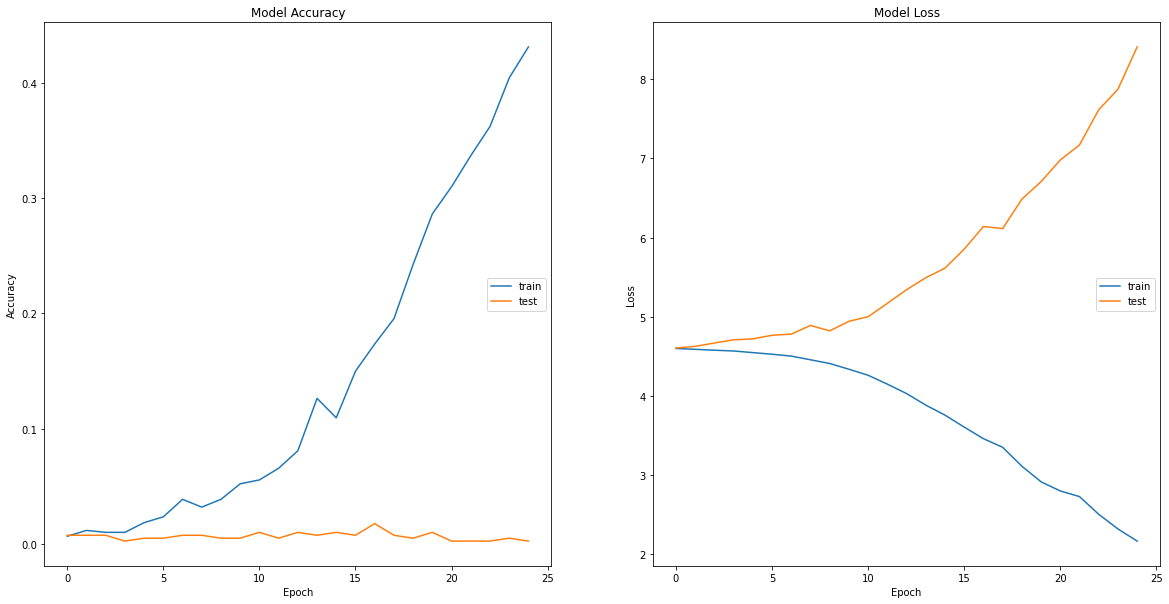

In [11]:
eval(hist_1)

#### Second Model

In [12]:
model_2 = generate_model(filters=[64,128], neurons=[128, 99])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 64)        0         
                                                                 
 conv_1 (Conv2D)             (None, 13, 13, 128)       73856     
                                                                 
 pool_1 (MaxPooling2D)       (None, 6, 6, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 fully_conn_0 (Dense)        (None, 128)               5899

In [13]:
hist_2 = fit(model_2, X, y, X_val, y_val, epochs=25, batch_size=32);

Epoch 1/25
19/19 [==============================] - 2s 43ms/step - loss: 4.6202 - accuracy: 0.0084 - val_loss: 4.5978 - val_accuracy: 0.0101
Epoch 2/25
19/19 [==============================] - 0s 15ms/step - loss: 4.5918 - accuracy: 0.0135 - val_loss: 4.6059 - val_accuracy: 0.0025
Epoch 3/25
19/19 [==============================] - 0s 14ms/step - loss: 4.5830 - accuracy: 0.0067 - val_loss: 4.6340 - val_accuracy: 0.0000e+00
Epoch 4/25
19/19 [==============================] - 0s 14ms/step - loss: 4.5564 - accuracy: 0.0202 - val_loss: 4.7108 - val_accuracy: 0.0000e+00
Epoch 5/25
19/19 [==============================] - 0s 13ms/step - loss: 4.4938 - accuracy: 0.0320 - val_loss: 4.7430 - val_accuracy: 0.0025
Epoch 6/25
19/19 [==============================] - 0s 12ms/step - loss: 4.3980 - accuracy: 0.0438 - val_loss: 4.8070 - val_accuracy: 0.0051
Epoch 7/25
19/19 [==============================] - 0s 14ms/step - loss: 4.2424 - accuracy: 0.0640 - val_loss: 4.9929 - val_accuracy: 0.0051
Epoch

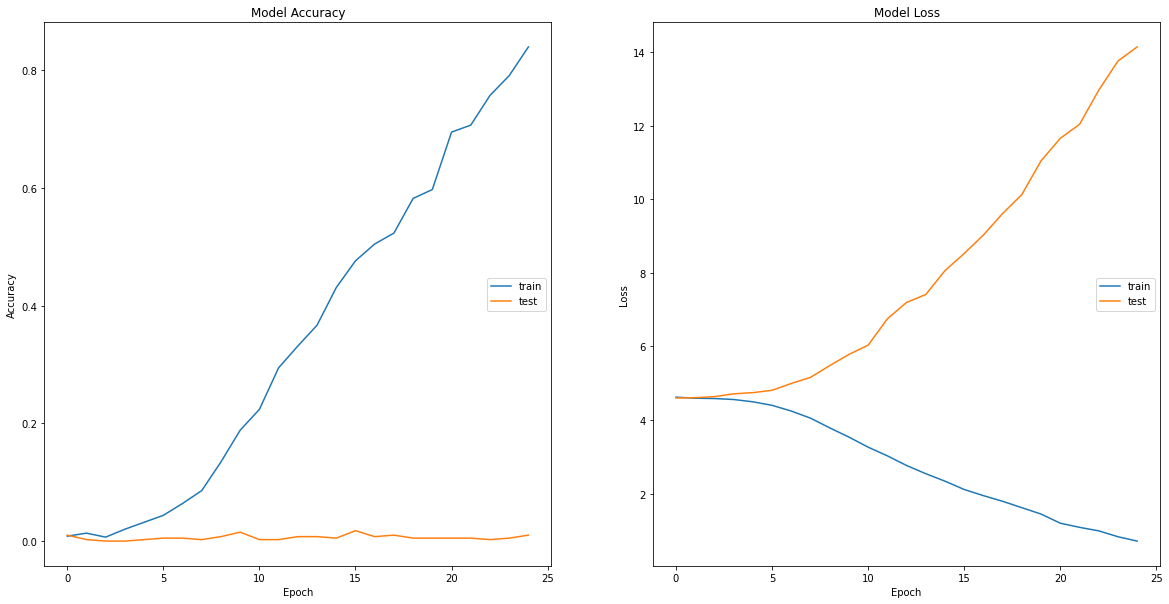

In [14]:
eval(hist_2)

#### Third Model

In [15]:
model_3 = generate_model(filters=[64,128,256], neurons=[128, 99], regularize=0.5)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 64)        0         
                                                                 
 conv_1 (Conv2D)             (None, 13, 13, 128)       73856     
                                                                 
 pool_1 (MaxPooling2D)       (None, 6, 6, 128)         0         
                                                                 
 conv_2 (Conv2D)             (None, 4, 4, 256)         295168    
                                                                 
 pool_2 (MaxPooling2D)       (None, 2, 2, 256)         0   

In [16]:
hist_3 = fit(model_3, X, y, X_val, y_val, epochs=10, batch_size=16);

Epoch 1/10
38/38 [==============================] - 2s 22ms/step - loss: 4.6120 - accuracy: 0.0118 - val_loss: 4.6010 - val_accuracy: 0.0025
Epoch 2/10
38/38 [==============================] - 0s 12ms/step - loss: 4.5921 - accuracy: 0.0118 - val_loss: 4.6145 - val_accuracy: 0.0025
Epoch 3/10
38/38 [==============================] - 0s 12ms/step - loss: 4.5920 - accuracy: 0.0084 - val_loss: 4.6160 - val_accuracy: 0.0025
Epoch 4/10
38/38 [==============================] - 0s 12ms/step - loss: 4.5820 - accuracy: 0.0084 - val_loss: 4.6600 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 0s 11ms/step - loss: 4.5814 - accuracy: 0.0135 - val_loss: 4.6411 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 0s 12ms/step - loss: 4.5741 - accuracy: 0.0118 - val_loss: 4.6825 - val_accuracy: 0.0025
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 4.5616 - accuracy: 0.0152 - val_loss: 4.6971 - val_accuracy: 0.0025
Epoch

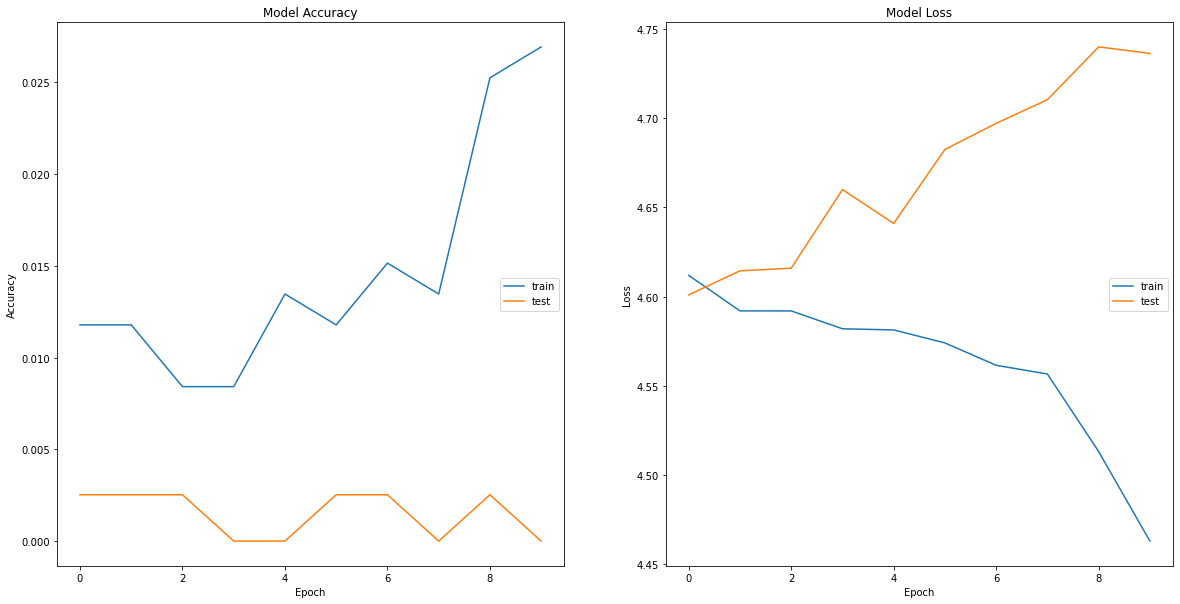

In [17]:
eval(hist_3)

#### Fourth Model

In [18]:
model_4 = generate_model(filters=[32, 64, 64], neurons=[128,99], regularize=0.2, input_shape=[256,256,1])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 1)]     0         
                                                                 
 conv_0 (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 pool_0 (MaxPooling2D)       (None, 127, 127, 32)      0         
                                                                 
 conv_1 (Conv2D)             (None, 125, 125, 64)      18496     
                                                                 
 pool_1 (MaxPooling2D)       (None, 62, 62, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 60, 64)        36928     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 30, 64)        0   

In [19]:
datagen = ImageDataGenerator(1./255)
train = X_train.copy()
labels = np.argmax(y_train, axis=1)
labels = label_encoder.inverse_transform(labels)
train = np.column_stack((train, labels))
df_train = pd.DataFrame(train, columns=['id', 'image', 'species'])
df_train = df_train.drop('image', axis=1)
df_train['id'] = df_train['id'] + '.jpg'

train_generator = datagen.flow_from_dataframe(dataframe=df_train, directory='.\\images\\train', 
                                              x_col='id', y_col='species', color_mode='grayscale',
                                              class_mode='categorical', target_size=(256,256), batch_size=16)

Found 594 validated image filenames belonging to 99 classes.


In [20]:
test = X_test.copy()
labels = np.argmax(y_test, axis=1)
labels = label_encoder.inverse_transform(labels)
test = np.column_stack((test, labels))
df_test = pd.DataFrame(test, columns=['id', 'image', 'species'])
df_test = df_test.drop('image', axis=1)
df_test['id'] = df_test['id'] + '.jpg'

test_generator = datagen.flow_from_dataframe(dataframe=df_test, directory='.\\images\\validation', 
                                              x_col='id', y_col='species', color_mode='grayscale',
                                              class_mode='categorical', target_size=(256,256), batch_size=16)

Found 396 validated image filenames belonging to 99 classes.


In [21]:
train_steps = train_generator.n // train_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

hist_4 = model_4.fit(x=train_generator, steps_per_epoch=train_steps, 
            validation_data=test_generator, validation_steps=test_steps, epochs=25);

Epoch 1/25
37/37 [==============================] - 4s 78ms/step - loss: 20.6931 - accuracy: 0.0156 - val_loss: 4.6073 - val_accuracy: 0.0078
Epoch 2/25
37/37 [==============================] - 3s 69ms/step - loss: 4.4453 - accuracy: 0.0398 - val_loss: 4.8261 - val_accuracy: 0.0052
Epoch 3/25
37/37 [==============================] - 3s 77ms/step - loss: 3.6492 - accuracy: 0.1644 - val_loss: 5.1928 - val_accuracy: 0.0052
Epoch 4/25
37/37 [==============================] - 3s 79ms/step - loss: 2.2638 - accuracy: 0.4343 - val_loss: 6.5239 - val_accuracy: 0.0052
Epoch 5/25
37/37 [==============================] - 2s 64ms/step - loss: 1.1362 - accuracy: 0.7095 - val_loss: 6.9440 - val_accuracy: 0.0026
Epoch 6/25
37/37 [==============================] - 3s 73ms/step - loss: 0.5642 - accuracy: 0.8512 - val_loss: 8.8393 - val_accuracy: 0.0026
Epoch 7/25
37/37 [==============================] - 3s 67ms/step - loss: 0.3589 - accuracy: 0.8979 - val_loss: 8.8447 - val_accuracy: 0.0078
Epoch 8/25
3

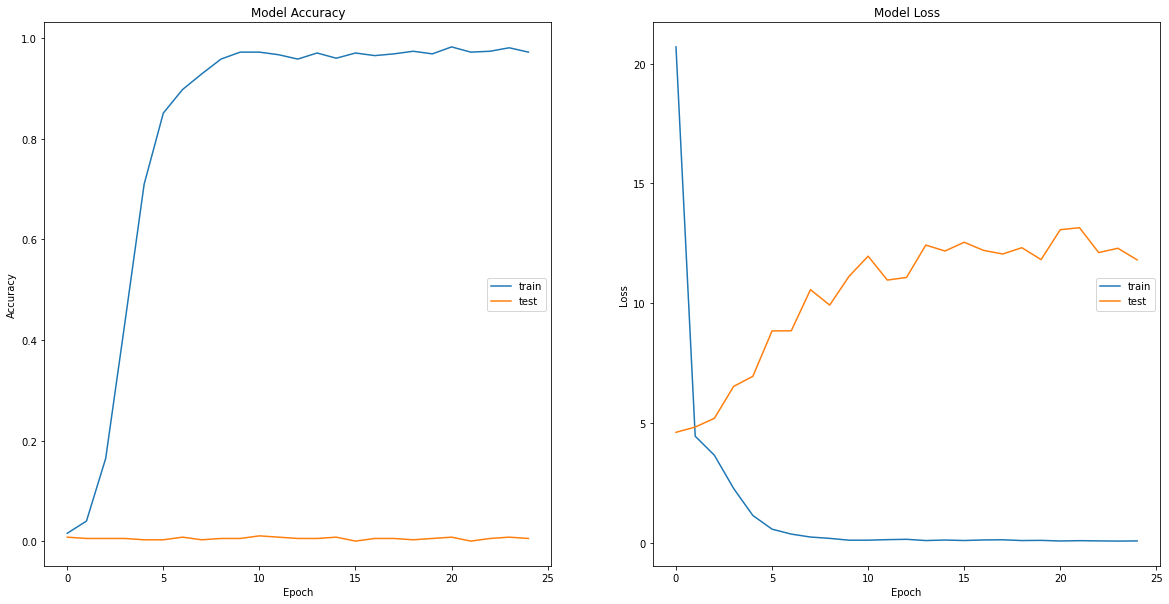

In [22]:
eval(pd.DataFrame(hist_4.history))

## Predictions

#### Test data pre-processing

In [23]:
test_data = pd.read_csv("test.csv")
move_files(id_list=test_data['id'], folder=TEST)
test = read_img(folder=TEST)
tf_test = tf.convert_to_tensor(list(test[:, 1]))

594 files moved to destination folder: .\images\test


In [24]:
y_pred_1 = model_1.predict(tf_test)

In [25]:
y_pred_2 = model_2.predict(tf_test)

In [26]:
y_pred_3 = model_3.predict(tf_test)

In [27]:
test = read_img(folder=TEST, size=(256, 256))
tf_test = tf.convert_to_tensor(list(test[:, 1]))
y_pred_4 = model_4.predict(tf_test)

## Submission

#### Auxiliary functions for submission

In [28]:
def submission_file(X, y, classes, filename=None):
    cols = ['id', *classes]
    data = np.column_stack((X, y))
    df = pd.DataFrame(data, columns=cols)
    df.set_index('id', inplace=True)
    df.to_csv(path_or_buf=filename)


#### First Model

In [29]:
submission_file(list(test[:, 0]), y_pred_1, label_encoder.classes_, "submission_model_1.csv")

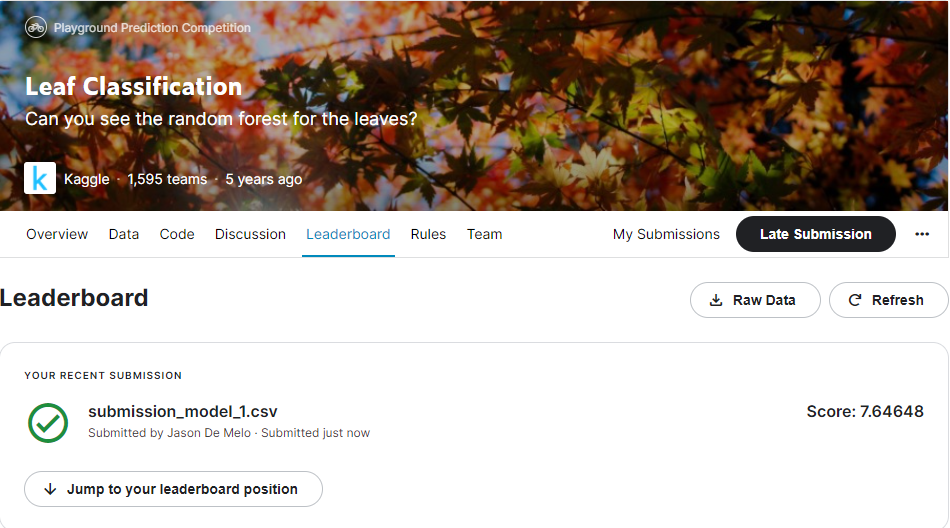

In [33]:
Image('submission_model_1.png')

#### Second Model

In [30]:
submission_file(list(test[:, 0]), y_pred_2, label_encoder.classes_, "submission_model_2.csv")

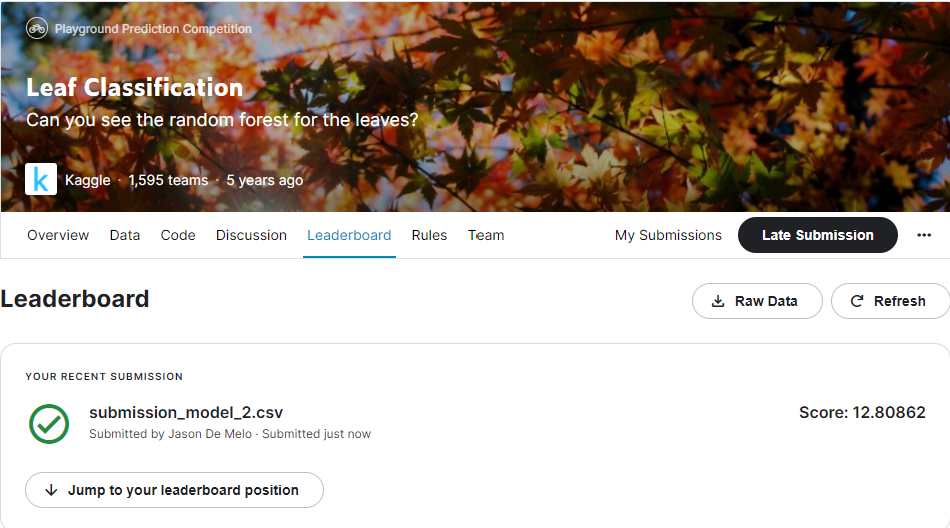

In [34]:
Image('submission_model_2.png')

#### Third Model

In [31]:
submission_file(list(test[:, 0]), y_pred_3, label_encoder.classes_, "submission_model_3.csv")

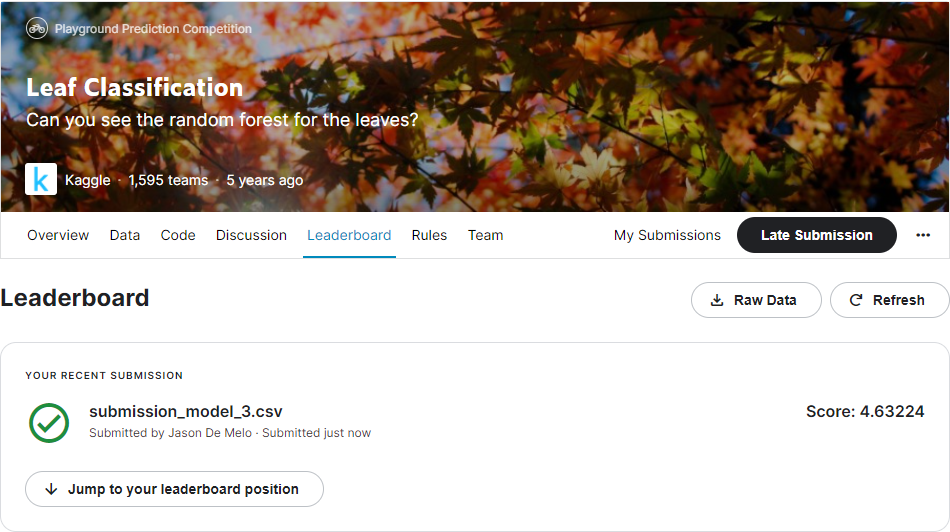

In [35]:
Image('submission_model_3.png')

#### Fourth Model

In [32]:
submission_file(list(test[:, 0]), y_pred_4, label_encoder.classes_, "submission_model_4.csv")

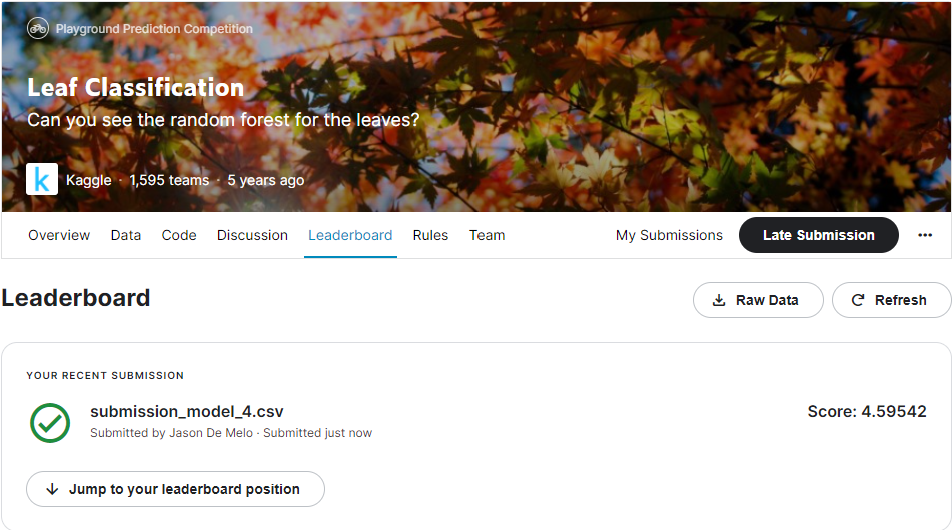

In [36]:
Image('submission_model_4.png')

## Conclusion

The first two models were generated with a more classic CNN architecture, with an input layer, then a series of ``Conv2D`` layers followed by pooling layers. At the end of the convolutional and pooling layers the output was flattened and then a series of full connected layers before the output layer. So far, both models didn't present a very good result.<br>
The third model had a regularization layer added to the full connected layers, by using ``Dropout`` layer. The third model produced a better result, even with processing only 10 epochs, as compared to 25 epochs for the first two models.<br>
Finnaly, the fourht model I used a different approach, by implementing a flow based on a dataframe containing the ``ID``, file name and species descriptions. Also, the size of the pictures were increased to 256x256 bytes. I have to believe this was probably the most important factor in producing the best result of all models. 